<h1>ロジスティック回帰モデル-タイタニック号の生存予測-</h1>

<h1>0. データ表示</h1>

In [1]:
#from モジュール名 import クラス名（もしくは関数名や変数名）
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#matplotlibをinlineで表示するためのおまじない (plt.show()しなくていい)
%matplotlib inline

In [2]:
# titanic data csvファイルの読み込み
titanic_df = pd.read_csv('data/titanic_train.csv')

In [3]:
# ファイルの先頭部を表示し、データセットを確認する
################################################################################
# 【レポート提出者変更】
# 引数変更
################################################################################
#titanic_df.head(3)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h1>1. ロジスティック回帰</h1>
<h3>不要なデータの削除・欠損値の補完</h3>

In [4]:
#予測に不要と考えるからうをドロップ (本当はここの情報もしっかり使うべきだと思っています)
titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

#一部カラムをドロップしたデータを表示
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
#nullを含んでいる行を表示
################################################################################
# 【レポート提出者変更】
# 引数変更
################################################################################
#titanic_df[titanic_df.isnull().any(1)].head(3)
titanic_df[titanic_df.isnull().any(1)].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,male,NaN,0,0,8.4583,Q
17,1,2,male,NaN,0,0,13.0000,S
19,1,3,female,NaN,0,0,7.2250,C
26,0,3,male,NaN,0,0,7.2250,C
28,1,3,female,NaN,0,0,7.8792,Q
29,0,3,male,NaN,0,0,7.8958,S
31,1,1,female,NaN,1,0,146.5208,C
32,1,3,female,NaN,0,0,7.7500,Q
36,1,3,male,NaN,0,0,7.2292,C
42,0,3,male,NaN,0,0,7.8958,C


In [6]:
#Ageカラムのnullを中央値で補完

titanic_df['AgeFill'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())

#再度nullを含んでいる行を表示 (Ageのnullは補完されている)
titanic_df[titanic_df.isnull().any(1)]

#titanic_df.dtypes

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill
5,0,3,male,NaN,0,0,8.4583,Q,29.699118
17,1,2,male,NaN,0,0,13.0000,S,29.699118
19,1,3,female,NaN,0,0,7.2250,C,29.699118
26,0,3,male,NaN,0,0,7.2250,C,29.699118
28,1,3,female,NaN,0,0,7.8792,Q,29.699118
29,0,3,male,NaN,0,0,7.8958,S,29.699118
31,1,1,female,NaN,1,0,146.5208,C,29.699118
32,1,3,female,NaN,0,0,7.7500,Q,29.699118
36,1,3,male,NaN,0,0,7.2292,C,29.699118
42,0,3,male,NaN,0,0,7.8958,C,29.699118


<h1>1. ロジスティック回帰</h1>
<h3>実装(チケット価格から生死を判別)</h3>

In [7]:
#運賃だけのリストを作成
data1 = titanic_df.loc[:, ["Fare"]].values

In [8]:
#生死フラグのみのリストを作成
label1 =  titanic_df.loc[:,["Survived"]].values

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
model=LogisticRegression()

In [11]:
model.fit(data1, label1)

/Users/honchi/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
################################################################################
# 【レポート提出者変更】
# predict/predict_proba追加
################################################################################
model.predict(62)

array([1])

In [13]:
model.predict_proba(62)

array([[ 0.49968899,  0.50031101]])

In [14]:
model.predict(data1)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0,

In [15]:
#これの絵を描く！！！！！
model.predict_proba(data1)

array([[ 0.69501393,  0.30498607],
       [ 0.4647799 ,  0.5352201 ],
       [ 0.69285391,  0.30714609],
       ..., 
       [ 0.64097142,  0.35902858],
       [ 0.6179592 ,  0.3820408 ],
       [ 0.69341474,  0.30658526]])

In [16]:
X_test_value = model.decision_function(data1) 

In [17]:
# # 決定関数値（絶対値が大きいほど識別境界から離れている）
# X_test_value = clf.decision_function(X_test) 
# # 決定関数値をシグモイド関数で確率に変換
# X_test_prob = sigmoid(X_test_value) 

In [18]:
print (model.intercept_)

print (model.coef_)

[-0.93290045]
[[ 0.01506685]]


/Users/honchi/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


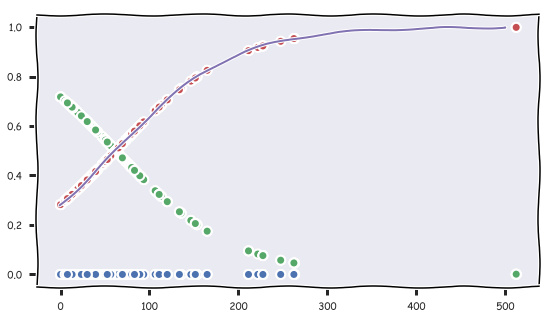

In [19]:
w_0 = model.intercept_[0]
w_1 = model.coef_[0,0]

# def normal_sigmoid(x):
#     return 1 / (1+np.exp(-x))

def sigmoid(x):
    return 1 / (1+np.exp(-(w_1*x+w_0)))

x_range = np.linspace(-1, 500, 3000)

plt.figure(figsize=(9,5))
plt.xkcd()
plt.legend(loc=2)


# plt.ylim(-0.1, 1.1)
# plt.xlim(-10, 10)

# plt.plot([-10,10],[0,0], "k", lw=1)
# plt.plot([0,0],[-1,1.5], "k", lw=1)
plt.plot(data1,np.zeros(len(data1)), 'o')
plt.plot(data1, model.predict_proba(data1), 'o')
plt.plot(x_range, sigmoid(x_range), '-')
#plt.plot(x_range, normal_sigmoid(x_range), '-')
#




<h1>1. ロジスティック回帰</h1>
<h3>実装(2変数から生死を判別)</h3>

In [20]:
#AgeFillの欠損値を埋めたので
#titanic_df = titanic_df.drop(['Age'], axis=1)

In [21]:
titanic_df['Gender'] = titanic_df['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [22]:
titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill,Gender
0,0,3,male,22.0,1,0,7.2500,S,22.0,1
1,1,1,female,38.0,1,0,71.2833,C,38.0,0
2,1,3,female,26.0,0,0,7.9250,S,26.0,0


In [23]:
################################################################################
# 【レポート提出者変更】
# コメント記載：社会階級が高く(数値が低い)、女性(数値が低い)は生き残りやすいのではないかという仮定
################################################################################
titanic_df['Pclass_Gender'] = titanic_df['Pclass'] + titanic_df['Gender']

In [24]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill,Gender,Pclass_Gender
0,0,3,male,22.0,1,0,7.2500,S,22.0,1,4
1,1,1,female,38.0,1,0,71.2833,C,38.0,0,1
2,1,3,female,26.0,0,0,7.9250,S,26.0,0,3
3,1,1,female,35.0,1,0,53.1000,S,35.0,0,1
4,0,3,male,35.0,0,0,8.0500,S,35.0,1,4


In [25]:
titanic_df = titanic_df.drop(['Pclass', 'Sex', 'Gender','Age'], axis=1)

In [26]:
titanic_df.head()

,Survived,SibSp,Parch,Fare,Embarked,AgeFill,Pclass_Gender
0,0,1,0,7.2500,S,22.0,4
1,1,1,0,71.2833,C,38.0,1
2,1,0,0,7.9250,S,26.0,3
3,1,1,0,53.1000,S,35.0,1
4,0,0,0,8.0500,S,35.0,4


In [27]:
# 重要だよ！！！
# 境界線の式
#   w_1・x + w_2・y + w_0 = 0
#   ⇒ y = (-w_1・x - w_0) / w_2
 
# # 境界線 プロット
# plt.plot([-2,2], map(lambda x: (-w_1 * x - w_0)/w_2, [-2,2]))
 
# # データを重ねる
# plt.scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='red', marker='x', label='train 0')
# plt.scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='blue', marker='x', label='train 1')
# plt.scatter(X_test_std[y_test==0, 0], X_test_std[y_test==0, 1], c='red', marker='o', s=60, label='test 0')
# plt.scatter(X_test_std[y_test==1, 0], X_test_std[y_test==1, 1], c='blue', marker='o', s=60, label='test 1')

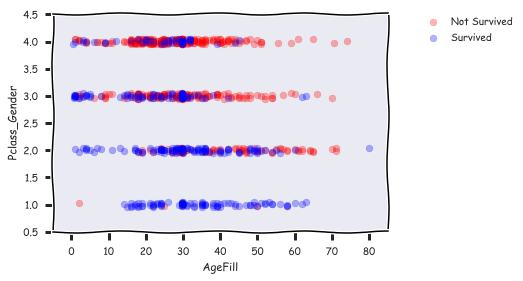

In [28]:
np.random.seed = 0

xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

index_survived = titanic_df[titanic_df["Survived"]==0].index
index_notsurvived = titanic_df[titanic_df["Survived"]==1].index

from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(bbox_to_anchor=(1.4, 1.03))

In [29]:
#運賃だけのリストを作成
data2 = titanic_df.loc[:, ["AgeFill", "Pclass_Gender"]].values

In [30]:
#生死フラグのみのリストを作成
label2 =  titanic_df.loc[:,["Survived"]].values

In [31]:
model2 = LogisticRegression()

In [32]:
model2.fit(data2, label2)

/Users/honchi/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
model2.predict(data2)

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0,

In [34]:
titanic_df.head(3)

,Survived,SibSp,Parch,Fare,Embarked,AgeFill,Pclass_Gender
0,0,1,0,7.2500,S,22.0,4
1,1,1,0,71.2833,C,38.0,1
2,1,0,0,7.9250,S,26.0,3


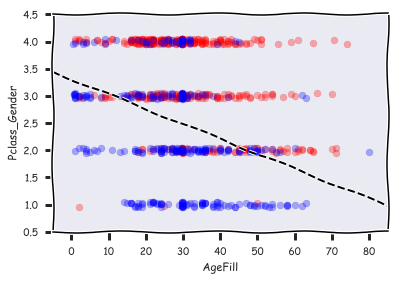

In [35]:
h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = model2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 1.0)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#contour = ax.contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.5)

sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)

ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
#fig.colorbar(contour)

x1 = xmin
x2 = xmax
y1 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmin)/model2.coef_[0][1]
y2 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmax)/model2.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--')

<h1>2. モデル評価</h1>
<h3>混同行列とクロスバリデーション</h3>

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
traindata1, testdata1, trainlabel1, testlabel1 = train_test_split(data1, label1, test_size=0.2)
traindata1.shape
trainlabel1.shape

(712, 1)

In [38]:
traindata2, testdata2, trainlabel2, testlabel2 = train_test_split(data2, label2, test_size=0.2)
traindata2.shape
trainlabel2.shape
#本来は同じデータセットを分割しなければいけない。(簡易的に別々に分割している。)

(712, 1)

In [39]:
data = titanic_df.loc[:, ].values
label =  titanic_df.loc[:,["Survived"]].values
traindata, testdata, trainlabel, testlabel = train_test_split(data, label, test_size=0.2)
traindata.shape
trainlabel.shape

(712, 1)

In [40]:
eval_model1=LogisticRegression()
eval_model2=LogisticRegression()
#eval_model=LogisticRegression()

In [41]:
predictor_eval1=eval_model1.fit(traindata1, trainlabel1).predict(testdata1)
predictor_eval2=eval_model2.fit(traindata2, trainlabel2).predict(testdata2)
#predictor_eval=eval_model.fit(traindata, trainlabel).predict(testdata)

/Users/honchi/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
eval_model1.score(traindata1, trainlabel1)

0.672752808988764

In [43]:
eval_model1.score(testdata1,testlabel1)

0.65363128491620115

In [44]:
eval_model2.score(traindata2, trainlabel2)

0.773876404494382

In [45]:
eval_model2.score(testdata2,testlabel2)

0.78212290502793291

In [46]:
from sklearn import metrics
print(metrics.classification_report(testlabel1, predictor_eval1))
print(metrics.classification_report(testlabel2, predictor_eval2))

             precision    recall  f1-score   support

          0       0.63      0.96      0.76       103
          1       0.82      0.24      0.37        76

avg / total       0.71      0.65      0.59       179

             precision    recall  f1-score   support

          0       0.82      0.82      0.82       108
          1       0.73      0.72      0.72        71

avg / total       0.78      0.78      0.78       179



In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix1=confusion_matrix(testlabel1, predictor_eval1)
confusion_matrix2=confusion_matrix(testlabel2, predictor_eval2)

In [48]:
confusion_matrix1

array([[99,  4],
       [58, 18]])

In [49]:
confusion_matrix2

array([[89, 19],
       [20, 51]])

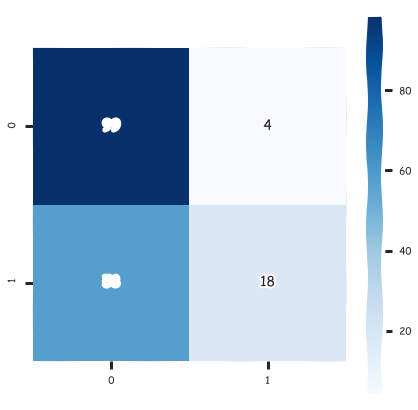

In [50]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix1,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

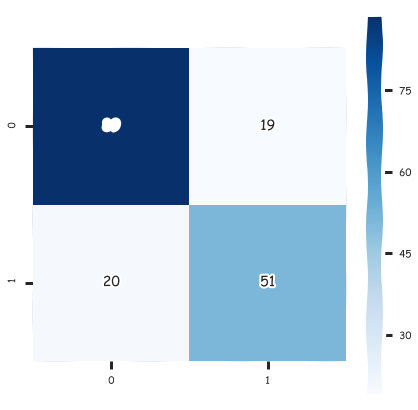

In [51]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix2,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

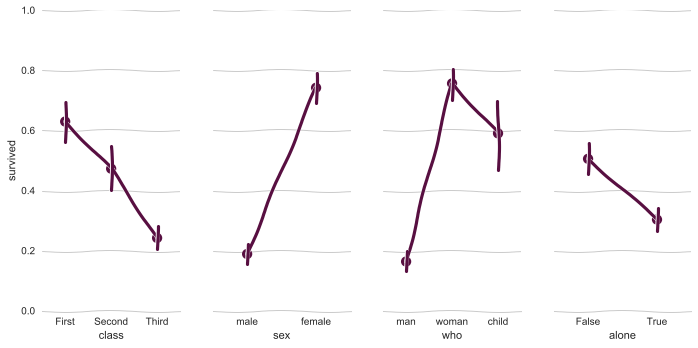

In [52]:
#Paired categorical plots

import seaborn as sns
sns.set(style="whitegrid")

# Load the example Titanic dataset
titanic = sns.load_dataset("titanic")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(titanic, y_vars="survived",
                 x_vars=["class", "sex", "who", "alone"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

plt.show()

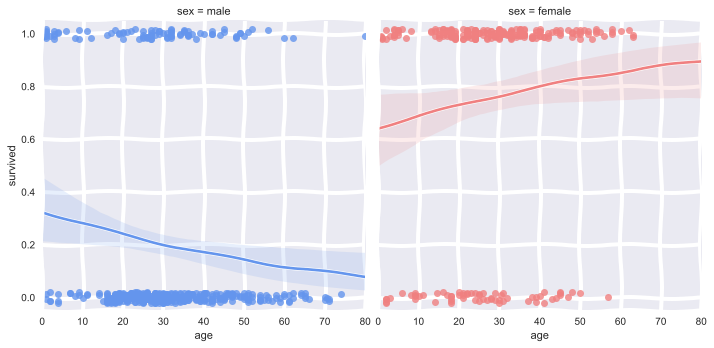

In [53]:
#Faceted logistic regression

import seaborn as sns
sns.set(style="darkgrid")

# Load the example titanic dataset
df = sns.load_dataset("titanic")

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))
plt.show()